# Regional and country-level averages

Area-weighted regional and country-level avg

To do:
- decide GWI 1.29 or 1.3 (rounded)
- redo with corrected Tw and WBGT 

In [1]:
# necessary:  netcdf4-python, regionmask (automatically imports xarray), Cartopy, openpyxl,( statsmodels - do i need this ?), seaborn, plotly

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns

import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.stats import norm

import sys, glob

In [2]:
from settings import *
from functions import * 
from utils import * 
from plotscript import * # is there anything here im using?
 

In [3]:
# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [4]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'shift_loglike': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_

In [5]:
# SETTINGS
figdir = os.path.join(figdirs, 'fig_feb25')

# plot settings
matplotlib.rc('axes',edgecolor='k')
fg_color = 'k' 

# geo information
landmask = get_mask()
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

dir_shift_fit = 'forster2024-hitol-nan'


In [6]:
def reporting_summary(df, args, axis=1, rounded=2):
    #summary = {arg: getattr(df, arg)(axis=axis) for arg in args}
    summary = {}
        # Iterate over each requested summary statistic
    for arg in args:
        if arg == "q1":
            summary["Q1"] = df.quantile(0.25, axis=axis)
        elif arg == "q3":
            summary["Q3"] = df.quantile(0.75, axis=axis)
        else:
            # Handle standard functions like "min", "max", "median"
            summary[arg] = getattr(df, arg)(axis=axis)
    
    # Concatenate results along columns
    df_summary = pd.concat(summary, axis=1)

    if isinstance(rounded, float):
        df_summary = df_summary.astype('float64').round(2)
    else:
        df_summary = df_summary.astype('float64')
    
    return df_summary

# 1. nAHD (WBGT28) 

## 1. Reanalysis
To do:

- check covariate value for present and GWI value (GHG=1.45, anthro=1.29 in 2023)


In [7]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params = xr.concat(da_list, dim="dataset")
    

In [8]:
gmst_smo = get_gmst_smo(ntime=4, observed_warming_path=observed_warming_path_annual)
#gmst_smo

In [9]:
threshold = 28
GWI=1.3
da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=GWI)
da_nAHD_obs.sum(dim=['lat','lon'])

<xarray.DataArray (dataset: 3)>
array([697534.49652436, 540681.1988157 , 775314.13316823])
Coordinates:
  * dataset  (dataset) <U11 'GSWP3-W5E5' '20CRv3-ERA5' '20CRv3-W5E5'

In [10]:
# threshold = 28
# GWI=1.29
# da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=GWI)
# da_nAHD_obs.sum(dim=['lat','lon'])

## 2. Climate models 


In [11]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) 
empty, da_p1_models = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=year)

# 2. IPCC AR6 land regions averages

In [12]:
regionmask.defined_regions.ar6.land

<regionmask.Regions 'AR6 reference regions (land only)'>
Source:   Iturbide et al., 2020 (ESSD)
overlap:  False

Regions:
 0 GIC Greenland/Iceland
 1 NWN N.W.North-America
 2 NEN N.E.North-America
 3 WNA   W.North-America
 4 CNA   C.North-America
..  ..               ...
41 EAU       E.Australia
42 SAU       S.Australia
43  NZ       New-Zealand
44 EAN      E.Antarctica
45 WAN      W.Antarctica

[46 regions]

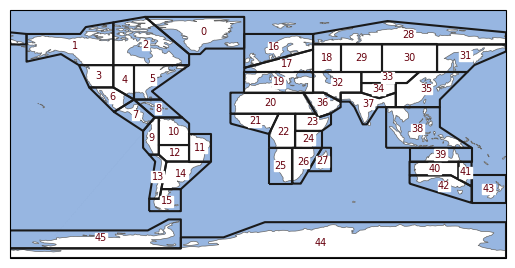

In [13]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

plot = regionmask.defined_regions.ar6.land.plot(text_kws=text_kws, add_ocean=True);

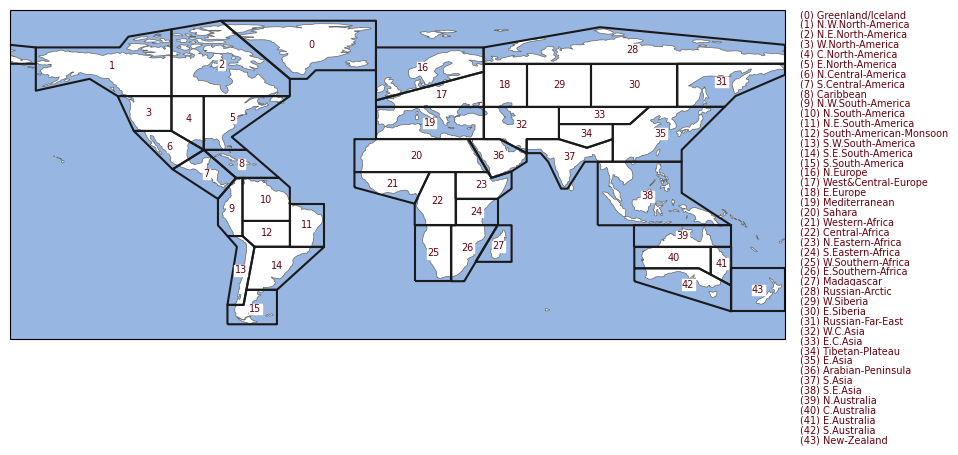

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create the map projection and axis
f, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define the text properties for region labels
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

# Plot the regions
indices = list(range(44))
regions = regionmask.defined_regions.ar6.land[indices]
plot = regions.plot(ax=ax, text_kws=text_kws, add_ocean=True)

# Get the region mask with names
mask = regions.mask_3D(da_nAHD_models)
region_labels = ['('+str(i)+') '+str(name) for i, name in zip(mask.region.values, mask.names.values)]

# Add the region labels as a list on the right side of the plot
for idx, label in enumerate(region_labels):
    ax.text(
        1.02, 1 - idx * 0.03,  # Coordinates for the label placement
        label,
        transform=ax.transAxes,   # Position relative to the axis (1.05, y) to place it outside the plot
        ha="left", va="top",
        color="#67000d",
        fontsize=7,
        bbox=dict(pad=0.2, color="w")
    )

# Save the figure
#plt.savefig(os.path.join(figdir,"IPCC_AR6_regions_labelled.png"), dpi=300, bbox_inches="tight")



In [15]:
mask = regionmask.defined_regions.ar6.land.mask_3D(da_nAHD_models)
mask.abbrevs

<xarray.DataArray 'abbrevs' (region: 46)>
array(['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR',
       'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE',
       'EEU', 'MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF',
       'MDG', 'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS',
       'ARP', 'SAS', 'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN',
       'WAN'], dtype='<U4')
Coordinates:
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
    abbrevs  (region) <U4 'GIC' 'NWN' 'NEN' 'WNA' ... 'SAU' 'NZ' 'EAN' 'WAN'
    names    (region) <U22 'Greenland/Iceland' ... 'W.Antarctica'

In [16]:
# regionlabels = [str(name)+' ('+str(i)+')' for i, name in zip(mask.region.values, mask.names.values) ]
# np.array(regionlabels)

# Get the region mask with names
region_labels = ['('+str(i)+') '+str(name) for i, name in zip(mask.region.values, mask.names.values)]


In [17]:
da_nAHD_mod_regional = da_nAHD_models.weighted(mask * cellarea).mean(dim=("lat", "lon"))
#da_nAHD_mod_regional.to_pandas().T

In [18]:
da_nAHD_obs_regional = da_nAHD_obs.weighted(mask * cellarea).mean(dim=("lat", "lon"))
#da_nAHD_obs_regional.to_pandas().T

In [19]:
df_mod = da_nAHD_mod_regional.to_pandas().T[0:44] # get rid of antarctica 44:45 
df_obs = da_nAHD_obs_regional.to_pandas().T[0:44]
df = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df

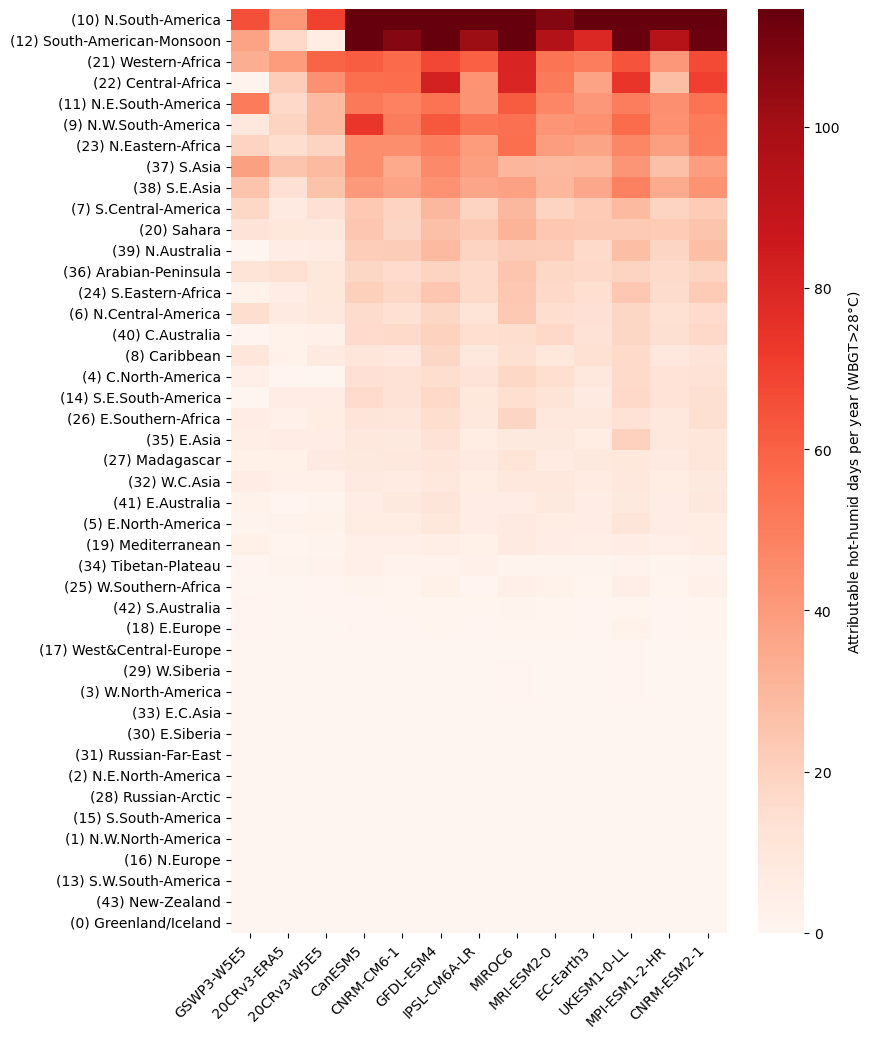

In [20]:
plt.figure(figsize=(8, 12))
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'Attributable hot-humid days per year (WBGT>28$\degree$C)'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"heatmap_nAHD_WBGT28_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")


In [21]:
df.min(), df.max()

(GSWP3-W5E5      -8.335509
 20CRv3-ERA5     -0.289173
 20CRv3-W5E5     -0.440450
 CanESM5          0.000000
 CNRM-CM6-1       0.000000
 GFDL-ESM4        0.000000
 IPSL-CM6A-LR    -0.001991
 MIROC6           0.000000
 MRI-ESM2-0       0.000000
 EC-Earth3        0.000000
 UKESM1-0-LL      0.000000
 MPI-ESM1-2-HR    0.000000
 CNRM-ESM2-1      0.000000
 dtype: float64,
 GSWP3-W5E5        65.518043
 20CRv3-ERA5       41.417546
 20CRv3-W5E5       70.183481
 CanESM5          164.507905
 CNRM-CM6-1       125.525051
 GFDL-ESM4        161.507107
 IPSL-CM6A-LR     126.409722
 MIROC6           128.536090
 MRI-ESM2-0       108.040318
 EC-Earth3        118.657638
 UKESM1-0-LL      145.565292
 MPI-ESM1-2-HR    115.002577
 CNRM-ESM2-1      124.028913
 dtype: float64)

### Plot

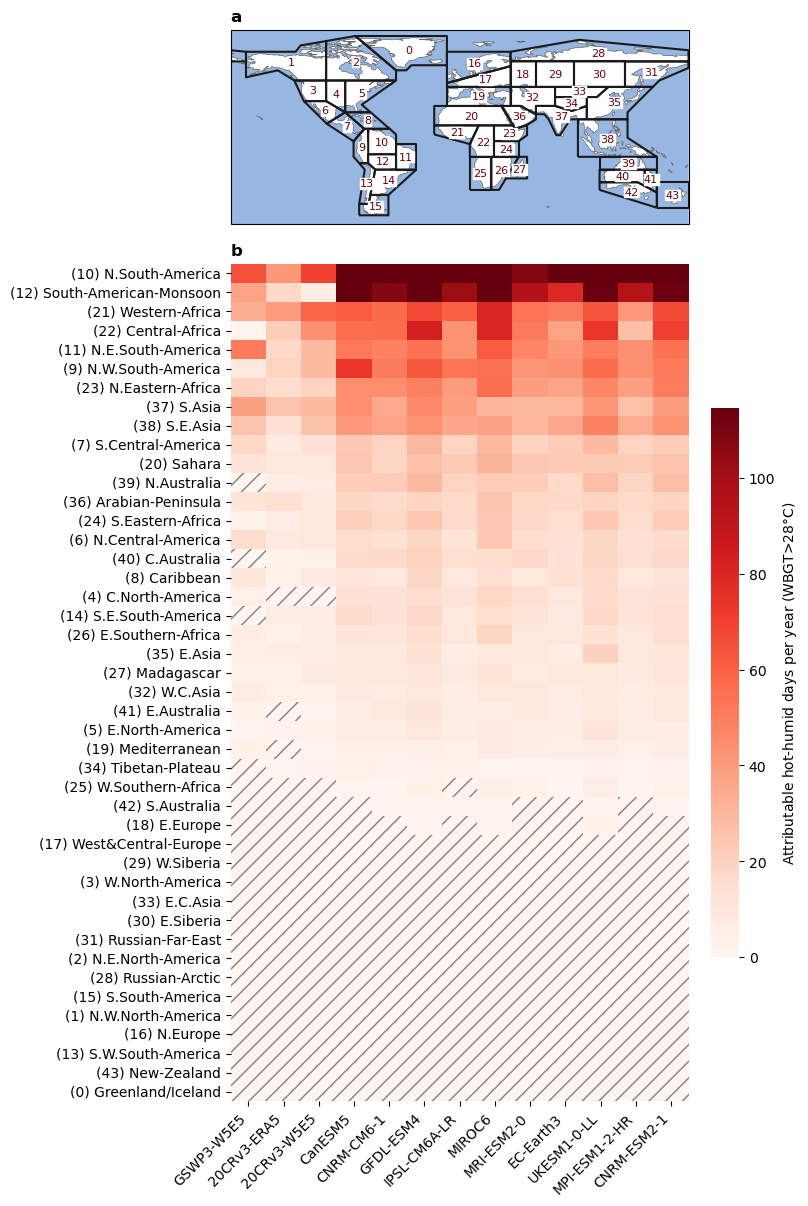

In [22]:
from matplotlib.colors import LogNorm


# Create fig and gridspec
fig = plt.figure(figsize=(8, 12), layout='constrained')  
gs = gridspec.GridSpec(2, 1, height_ratios=[1,4],figure=fig)  


# Plot the regions
ax= fig.add_subplot(gs[0, 0], projection= ccrs.PlateCarree()) 
text_kws = dict(color="#67000d", fontsize=8, bbox=dict(pad=0.2, color="w")) # Define the text properties for region labels
indices = list(range(44))
regions = regionmask.defined_regions.ar6.land[indices] # subselect regions w/out Antarctica
plot = regions.plot(ax=ax, text_kws=text_kws, add_ocean=True) # plot 
ax.set_title('a', loc='left', fontweight='bold')

# Plot heatmap
ax= fig.add_subplot(gs[1, 0])  
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, ax=ax, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'Attributable hot-humid days per year (WBGT>28$\degree$C)', 'fraction': 0.06})
plt.xticks(rotation=45, ha='right');
ax.set_title('b', loc='left',fontweight='bold')


data = df_sorted.values

# Overlay hatching for cells where values are less than 1
hatch_mask = data < 1 
# Apply hatching by using pcolor on masked areas
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, hatch='//', fill=False, edgecolor='gray', linewidth=0))


##plt.savefig(os.path.join(figdir,"figSI_heatmap_nAHD_WBGT28_IPCC_AR6_regions_v2.png"), dpi=300, bbox_inches="tight")

### Reporting tables (to save/format/export)

Pick multi-model mean+range or median+IQR

In [23]:
df_obs = df.iloc[:, 0:3]
df_obs_summary=reporting_summary(df_obs, ['mean', 'median', 'min', 'max', 'q1', 'q3'])
df_obs_summary.sort_values('median', ascending=False)

#df_obs_summary.to_csv()

,mean,median,min,max,Q1,Q3
(10) N.South-America,59.039690,65.518043,41.417546,70.183481,53.467794,67.850762
(21) Western-Africa,43.975265,39.502745,33.174384,59.248666,36.338565,49.375706
(37) S.Asia,30.731614,28.931536,25.077625,38.185680,27.004580,33.558608
(11) N.E.South-America,32.392651,28.668449,17.328130,51.181373,22.998289,39.924911
(38) S.E.Asia,21.593863,25.488950,13.614711,25.677930,19.551830,25.583440
(22) Central-Africa,22.319840,21.559333,1.595553,43.804633,11.577443,32.681983
(23) N.Eastern-Africa,18.089215,19.420802,15.264620,19.582222,17.342711,19.501512
(9) N.W.South-America,19.089193,19.337556,8.965941,28.964081,14.151749,24.150819
(12) South-American-Monsoon,20.474300,17.411125,6.463555,37.548221,11.937340,27.479673
(7) S.Central-America,13.055350,13.489984,7.800685,17.875380,10.645335,15.682682


In [24]:
df_mod = df.iloc[:, 3:]
df_mod_summary=reporting_summary(df_mod, ['mean', 'median', 'min', 'max', 'q1','q3'])
df_mod_summary.sort_values('median', ascending=False).round(0)


,mean,median,min,max,Q1,Q3
(10) N.South-America,132.0,126.0,108.0,165.0,120.0,141.0
(12) South-American-Monsoon,109.0,111.0,80.0,134.0,97.0,116.0
(21) Western-Africa,60.0,61.0,41.0,81.0,54.0,66.0
(22) Central-Africa,58.0,56.0,28.0,83.0,45.0,73.0
(9) N.W.South-America,53.0,52.0,42.0,74.0,45.0,56.0
(11) N.E.South-America,49.0,50.0,41.0,62.0,45.0,53.0
(23) N.Eastern-Africa,45.0,45.0,37.0,56.0,39.0,49.0
(38) S.E.Asia,39.0,38.0,30.0,49.0,36.0,42.0
(37) S.Asia,36.0,37.0,27.0,46.0,30.0,41.0
(20) Sahara,24.0,24.0,19.0,31.0,23.0,25.0


# 3. IPCC AR6 regions People x days (remove?)


In [25]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## young people

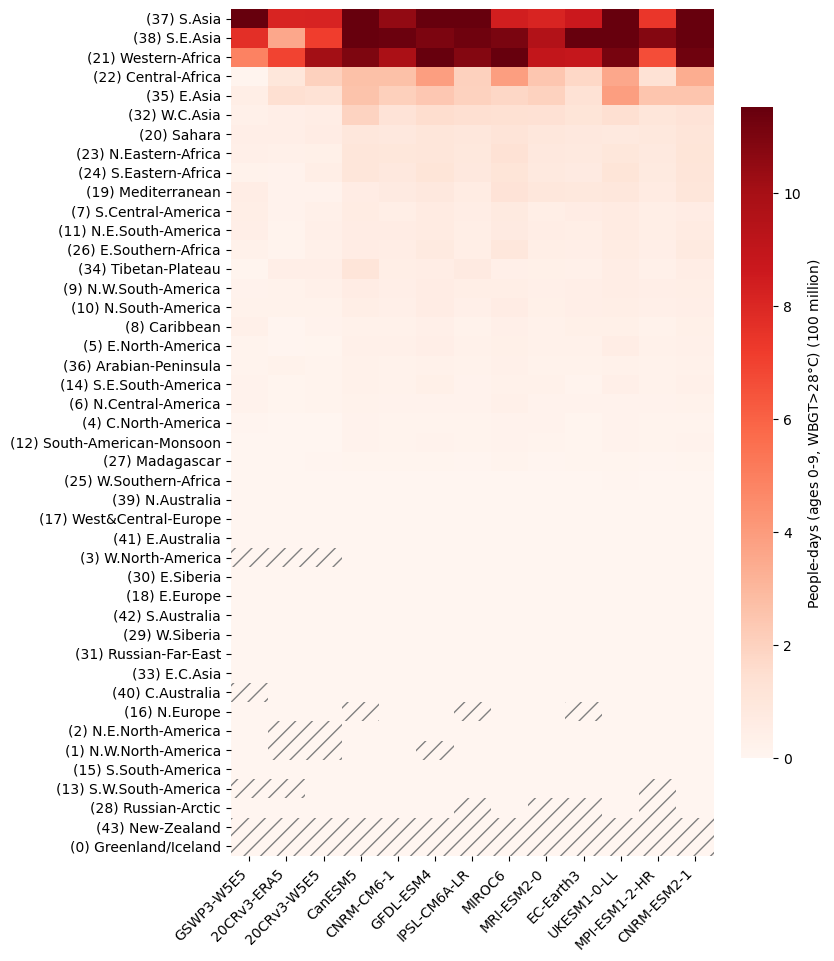

In [26]:
people_days_models = (da_nAHD_models * gs_population_global.sel(ages=0).squeeze('time'))
people_days_obs = (da_nAHD_obs * gs_population_global.sel(ages=0).squeeze('time'))

peopledays_mod_regional = people_days_models.weighted(mask).sum(dim=("lat", "lon")).isel(region=slice(0,44))
#peopledays_mod_regional.to_pandas().T

peopledays_obs_regional = people_days_obs.weighted(mask).sum(dim=("lat", "lon")).isel(region=slice(0,44))
#peopledays_obs_regional.to_pandas().T

df_mod = peopledays_mod_regional.to_pandas().T
df_obs = peopledays_obs_regional.to_pandas().T
df_peopledays = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df_peopledays

fig, ax = plt.subplots(figsize=(7, 11))

df_sorted = df_peopledays.loc[df_peopledays.mean(axis=1).sort_values(ascending=False).index.values] / 1e8
sns.heatmap(df_sorted, ax=ax,annot=False, cmap='Reds', robust=True,  cbar=True, cbar_kws={'label':'People-days (ages 0-9, WBGT>28$\degree$C) (100 million)', 'fraction': 0.06}) #

plt.xticks(rotation=45, ha='right');

data = df_sorted.values

# Overlay hatching for cells where values are less than 1
hatch_mask = data < ( 1e2 / 1e8)
# Apply hatching by using pcolor on masked areas
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, hatch='//', fill=False, edgecolor='gray', linewidth=0))


#plt.savefig(os.path.join(figdir,"figSI_peopledays_09_heatmap_IPCC_AR6_regions_v2.png"), dpi=300, bbox_inches="tight")

## older people

In [27]:
people_days_models = (da_nAHD_models * gs_population_global.sel(ages=60).squeeze('time'))
people_days_obs = (da_nAHD_obs * gs_population_global.sel(ages=60).squeeze('time'))

peopledays_mod_regional = people_days_models.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_mod_regional.to_pandas().T

peopledays_obs_regional = people_days_obs.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_obs_regional.to_pandas().T

df_mod = peopledays_mod_regional.to_pandas().T[0:44]
df_obs = peopledays_obs_regional.to_pandas().T[0:44]
df_peopledays_60 = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df_peopledays

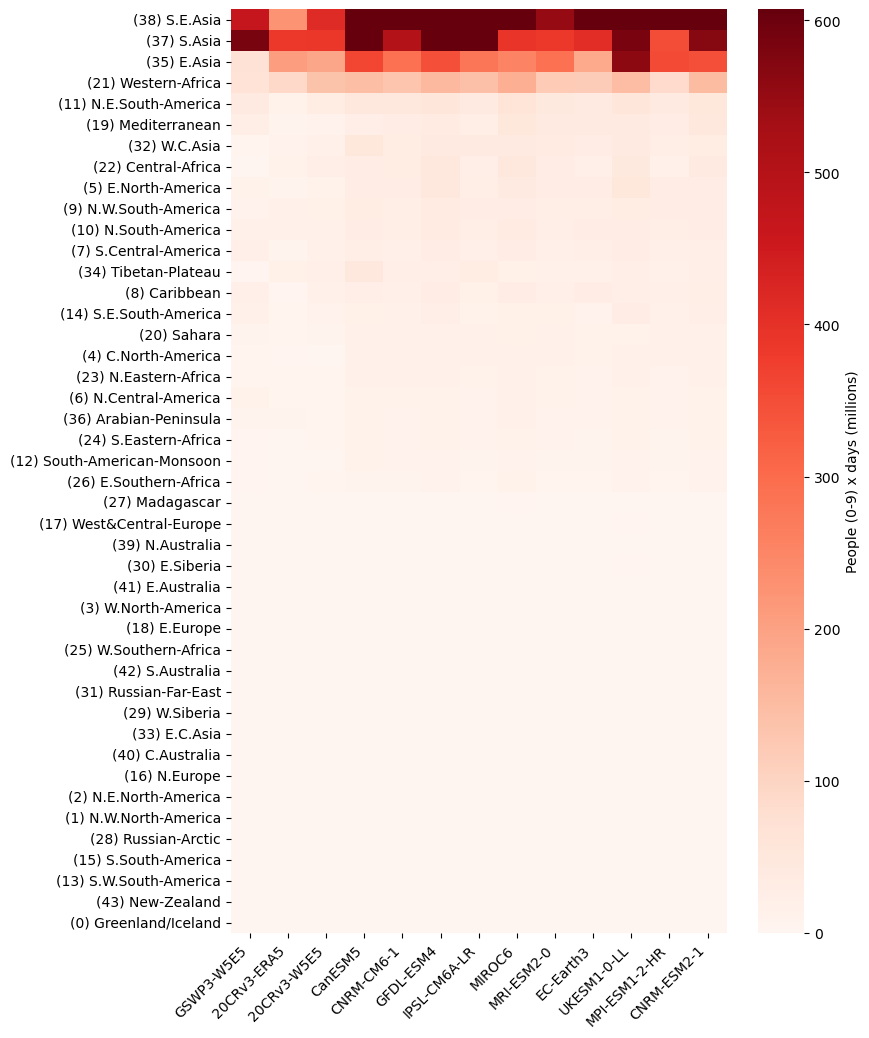

In [28]:
plt.figure(figsize=(8, 12))
df_sorted = df_peopledays_60.loc[df_peopledays_60.mean(axis=1).sort_values(ascending=False).index.values] / 1e6
sns.heatmap(df_sorted, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'People (0-9) x days (millions)'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"heatmap_nAHD_WBGT28_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")

## ratio younger / older peoplexdays in each region

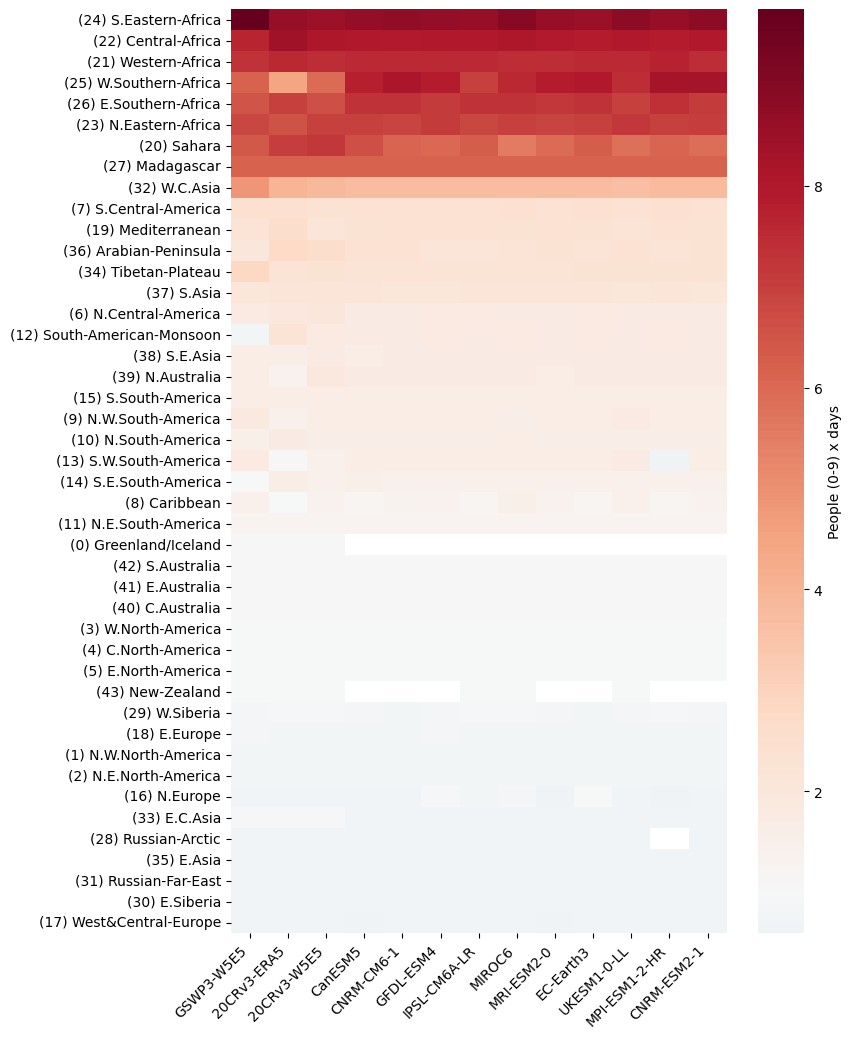

In [29]:
plt.figure(figsize=(8, 12))
df = df_peopledays / df_peopledays_60
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='RdBu_r', center=1, robust=False, cbar=True, cbar_kws={'label':'People (0-9) x days'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio younger / older people

In [30]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_old = gs_population_global.sel(ages=60).squeeze('time')

people_young_regional = people_young.weighted(mask).sum(dim=("lat", "lon"))
people_old_regional = people_old.weighted(mask).sum(dim=("lat", "lon"))

df_young = pd.DataFrame(people_young_regional.to_pandas().T)[0:44].set_index(np.array(region_labels)[0:44])
df_old = pd.DataFrame(people_old_regional.to_pandas().T)[0:44].set_index(np.array(region_labels)[0:44])



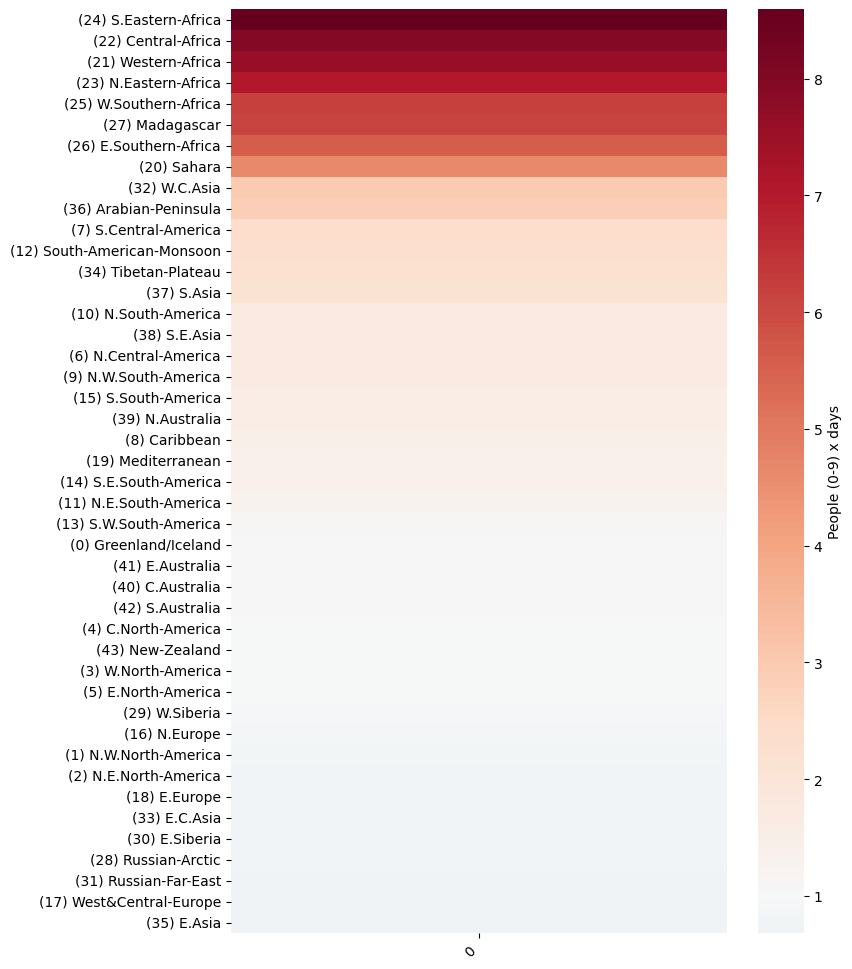

In [31]:
plt.figure(figsize=(8, 12))
df = df_young / df_old
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='RdBu_r', center=1, robust=False, cbar=True, cbar_kws={'label':'People (0-9) x days'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio young peoplexdays to total global peoplexdays


In [32]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_tot = gs_population_global.sum(dim='ages').squeeze('time') #

people_days_young = (da_nAHD_models * people_young)
people_days_tot = (da_nAHD_models * people_tot ).sum(dim=("lat", "lon"))

peopledays_frac_regional = people_days_young.weighted(mask).sum(dim=("lat", "lon")) / people_days_tot

df_models = pd.DataFrame(peopledays_frac_regional.to_pandas().T )[0:44].set_index(np.array(region_labels)[0:44])
#df_models


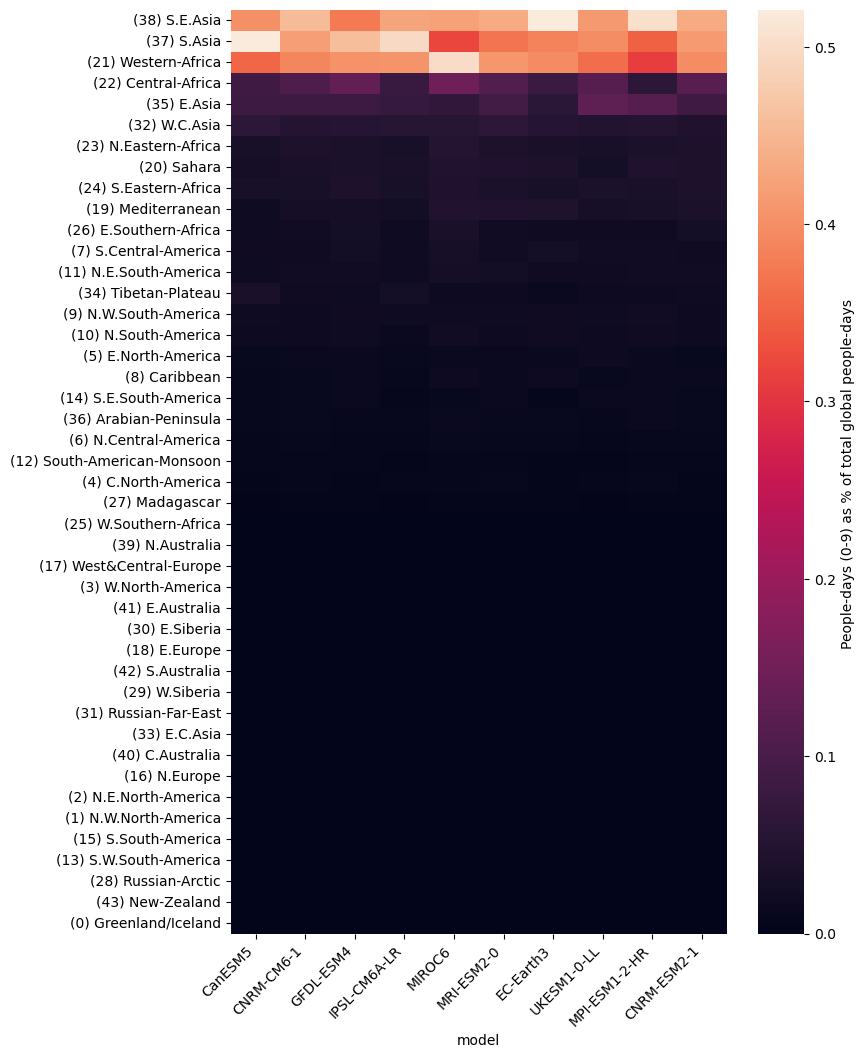

In [33]:
plt.figure(figsize=(8, 12))
df = df_models * 100
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values] 
sns.heatmap(df_sorted, annot=False,   robust=False, cbar=True, cbar_kws={'label':'People-days (0-9) as % of total global people-days '})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio young peoplexdays to young total global peoplexdays


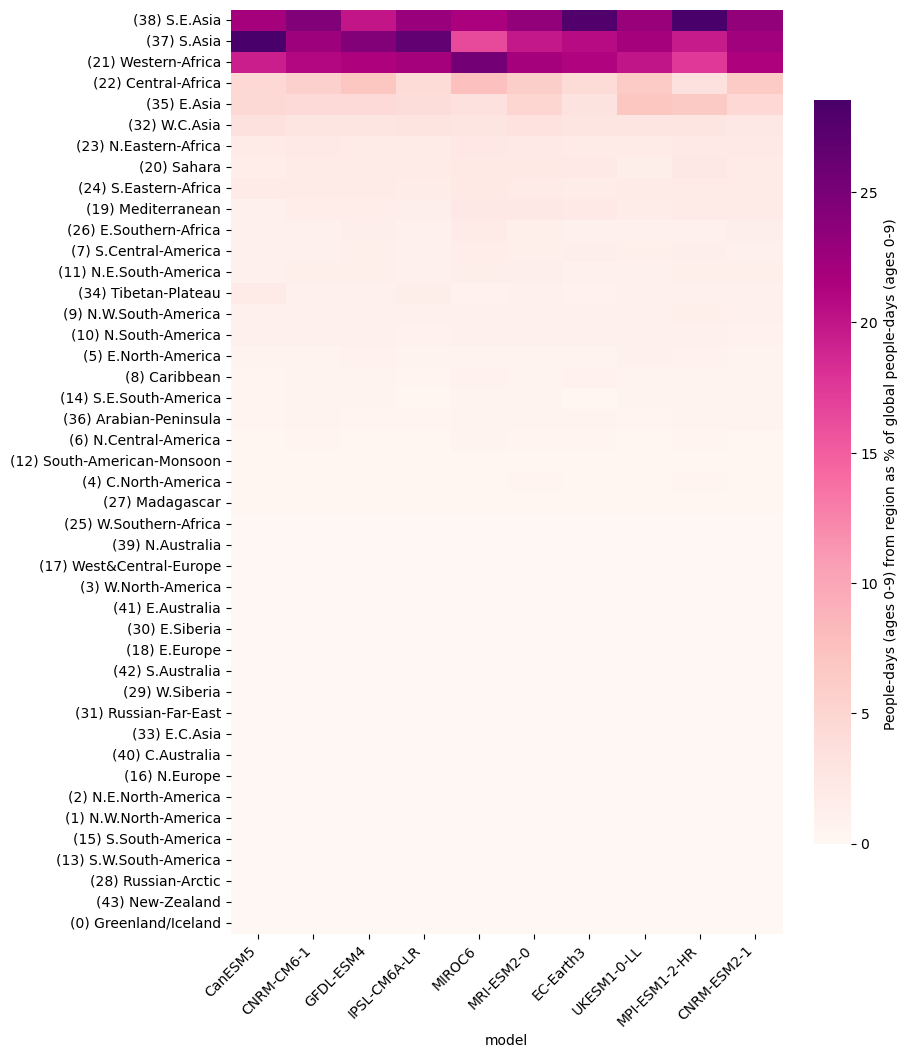

In [34]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_tot = gs_population_global.sel(ages=0).squeeze('time') #

people_days_young = (da_nAHD_models * people_young)
people_days_tot = (da_nAHD_models * people_tot ).sum(dim=("lat", "lon"))

peopledays_frac_regional = people_days_young.weighted(mask).sum(dim=("lat", "lon")) / people_days_tot

df_models = pd.DataFrame(peopledays_frac_regional.to_pandas().T )[0:44].set_index(np.array(region_labels)[0:44])

plt.figure(figsize=(8, 12))
df = df_models * 100
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values] 
sns.heatmap(df_sorted, annot=False,   robust=False, cbar=True, cmap='RdPu', cbar_kws={'label':'People-days (ages 0-9) from region as % of global people-days (ages 0-9) ', 'fraction': 0.06})

plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"figSI_peopledays_percentage09_heatmap_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")

In [35]:
df_models.sum(axis=0)

model
CanESM5          0.993806
CNRM-CM6-1       0.992712
GFDL-ESM4        0.991848
IPSL-CM6A-LR     0.993557
MIROC6           0.994121
MRI-ESM2-0       0.993080
EC-Earth3        0.992186
UKESM1-0-LL      0.993387
MPI-ESM1-2-HR    0.991335
CNRM-ESM2-1      0.992825
dtype: float64

# 4. Country-level results

## climate

In [36]:
countrymasks = load_countrymasks_fillcoasts() # from demographics4climate
countrymasks_nan = countrymasks.where(countrymasks > 0)

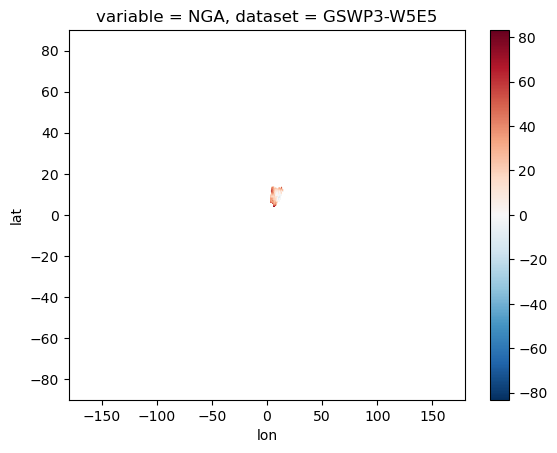

In [37]:
(countrymasks_nan * da_nAHD_obs).sel(variable='NGA').isel(dataset=0).plot()

In [38]:
# per country area-weighted mean nAHD per year

df_nAHD_countries = (countrymasks_nan * da_nAHD_obs).weighted(cellarea).mean(dim=['lat','lon']).to_pandas()
#df_nAHD_countries.sort_values(by='GSWP3-W5E5', ascending=False)

In [39]:
df = df_nAHD_countries
df_nAHD_countries_summary = reporting_summary(df, ['median', 'min', 'max'])
df_nAHD_countries_summary

,median,min,max
variable,,,
AFG,0.357271,0.342443,0.447967
AGO,0.865023,0.651791,3.747389
ALB,1.468259,0.138663,1.720573
AND,0.000788,0.000061,0.000798
ARE,11.347561,8.768438,12.082198
...,...,...,...
WSM,0.264742,0.264742,0.392716
YEM,8.277427,4.549544,13.686286
ZAF,2.030300,0.654324,2.159579


## demographics (WCDE v2)

In [40]:
df_cohort_sizes_ssp2, ages, years = load_cohort_sizes(ssp=2)
da_cohort_sizes = interpolate_cohortsize_countries(df_cohort_sizes_ssp2,
                                                 ages,
                                                 years)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [41]:
# fraction of 0-9 yo in each country

da_nkids = da_cohort_sizes.sel(time=2023).sel(ages=slice(0,9)).sum(axis=1) 
da_npop =da_cohort_sizes.sel(time=2023).sum(dim='ages') 
df_fraction_kids = (da_nkids / da_npop).to_pandas()
df_fraction_kids.name = 'fraction_children'
df_fraction_kids = pd.DataFrame(df_fraction_kids)

#da_npop.to_pandas() # * times 10^3 (unit: thousands of ppl)

In [42]:
df_fraction_kids.sort_values(by='fraction_children', ascending=False).head(20) 

,fraction_children
country,
Niger,0.347177
Uganda,0.325665
Somalia,0.314623
Chad,0.311744
Mali,0.311199
Zambia,0.305380
Democratic Republic of the Congo,0.304686
Malawi,0.302374
Burkina Faso,0.301099


In [43]:
df_countries_matched = match_country_names_all_mask_frac();
df_countries_matched

Unmatched ISIMIP countries (without WCDE data) after all merges:
                   country           country_wb
194                Andorra              Andorra
196               Dominica             Dominica
199                  Palau                Palau
7            Liechtenstein        Liechtenstein
8         Marshall Islands     Marshall Islands
9                   Monaco               Monaco
10                   Nauru                Nauru
12   Saint Kitts and Nevis  St. Kitts and Nevis
13              San Marino           San Marino
14                  Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
                                   country_wcde
2                                         Aruba
3                               Channel Islands
4                                       Curaçao
5  Macao Special Administrative Region of China
6                                         World
Unmatched ISIMIP mask countries (geojson + frac mask) after all merges:
    

,country,country_wb,country_wcde,country_mask,country_iso3,iso3_mask,iso3_frac,country_code,region,income_group
0,Afghanistan,Afghanistan,Afghanistan,Afghanistan,AFG,AFG,AFG,3.0,South Asia,Low income
1,Albania,Albania,Albania,Albania,ALB,ALB,ALB,103.0,Europe & Central Asia,Upper middle income
2,Algeria,Algeria,Algeria,Algeria,DZA,DZA,DZA,203.0,Middle East & North Africa,Upper middle income
3,Andorra,Andorra,None,Andorra,AND,AND,AND,403.0,Europe & Central Asia,High income
4,Angola,Angola,Angola,Angola,AGO,AGO,AGO,503.0,Sub-Saharan Africa,Lower middle income
...,...,...,...,...,...,...,...,...,...,...
228,NaN,NaN,NaN,NaN,NaN,NaN,MNP,NaN,NaN,NaN
229,NaN,NaN,NaN,NaN,NaN,NaN,PSID,NaN,NaN,NaN
230,NaN,NaN,NaN,NaN,NaN,NaN,SXM,NaN,NaN,NaN
231,NaN,NaN,NaN,NaN,NaN,NaN,TCA,NaN,NaN,NaN


In [44]:
df_countries_matched[['country_wcde', 'iso3_frac']].dropna()

,country_wcde,iso3_frac
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
4,Angola,AGO
5,Antigua and Barbuda,ATG
...,...,...
206,Puerto Rico,PRI
207,Reunion,REU
208,Taiwan Province of China,TWN
209,United States Virgin Islands,VIR


In [45]:
df_merge = df_countries_matched[['country_wcde', 'iso3_frac']].dropna().merge(df_fraction_kids, right_index=True, left_on='country_wcde').merge(df_nAHD_countries_summary, left_on='iso3_frac', right_index=True)
df_merge

,country_wcde,iso3_frac,fraction_children,median,min,max
0,Afghanistan,AFG,0.298030,0.357271,0.342443,0.447967
1,Albania,ALB,0.109632,1.468259,0.138663,1.720573
2,Algeria,DZA,0.187687,4.611708,3.228542,7.003012
4,Angola,AGO,0.300603,0.865023,0.651791,3.747389
5,Antigua and Barbuda,ATG,0.148190,0.006277,0.006277,0.217581
...,...,...,...,...,...,...
206,Puerto Rico,PRI,0.106784,42.168226,0.358095,74.351977
207,Reunion,REU,0.143758,0.100077,0.004303,0.158196
208,Taiwan Province of China,TWN,0.082164,18.351388,10.817595,20.994039
209,United States Virgin Islands,VIR,0.121933,0.025876,0.025876,0.575041


Text(0.5, 1.0, 'nAHD per year')

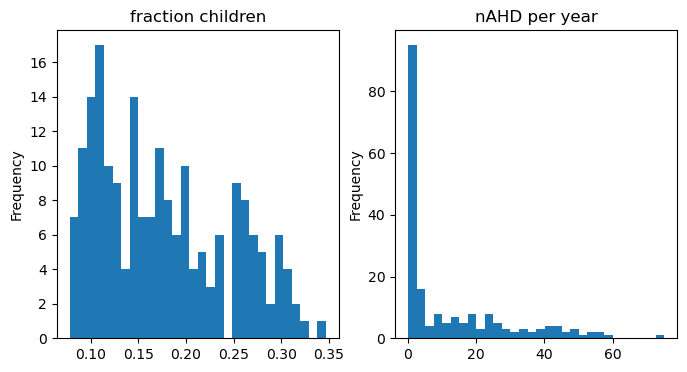

In [46]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

ax=axes[0]
df_merge.fraction_children.plot.hist(ax=ax,bins=30)
ax.set_title('fraction children')

ax=axes[1]
df_merge['median'].plot.hist(ax=ax,bins=30)
ax.set_title('nAHD per year')


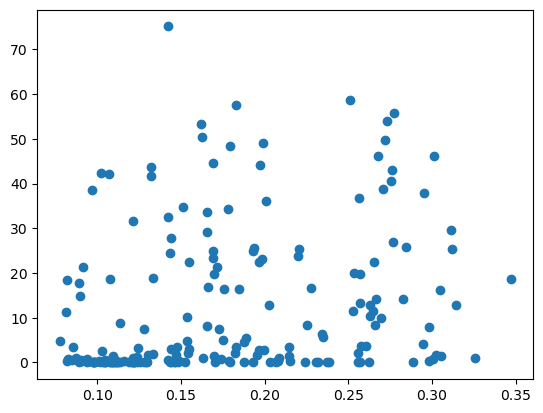

In [47]:
plt.scatter(df_merge['fraction_children'],df_merge['median'] )

In [48]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

# Calculate error bars
df_merge['error_y_minus'] = df_merge['median'] - df_merge['min']  # Difference from median to min
df_merge['error_y_plus'] = df_merge['max'] - df_merge['median']  # Difference from median to max


fig = px.scatter(
    df_merge,
    x='fraction_children',
    y='median',
    error_y='error_y_plus',  # Upper error bar
    error_y_minus='error_y_minus',  # Lower error bar
    hover_name='country_wcde',  # Column to show on hover
    hover_data={'min': True, 'max': True},
    title="Interactive Scatter Plot"
)
# Save as HTML
#fig.show()


ModuleNotFoundError: No module named 'plotly'

In [ ]:
df_merge.drop(columns=['error_y_minus','error_y_plus']).sort_values(by='fraction_children', ascending=False).head(20)

In [ ]:
df_merge[df_merge['country_wcde'].str.startswith('United')].drop(columns=['error_y_minus','error_y_plus'])


In [ ]:
df_merge[df_merge['country_wcde'].str.startswith('France')].drop(columns=['error_y_minus','error_y_plus'])


In [ ]:
df_merge[df_merge['country_wcde'].str.startswith('Germany')].drop(columns=['error_y_minus','error_y_plus'])


# 5. Global cohort sizes


In [ ]:
da_cohort_sizes.sel(time=2023).sel(country='World').sum().values # units (000's)

In [ ]:
da_cohort_sizes.sel(time=2023).sel(country='World').sel(ages=slice(0,9)).sum().values

In [ ]:
da_cohort_sizes.sel(time=2023).sel(country='World').sel(ages=slice(60,69)).sum().values

In [ ]:
da_cohort_sizes.sel(time=2023).sel(country='World').sel(ages=slice(80,89)).sum().values

## cfr w/ updated WCDE v3 data

### country-level

In [ ]:
df_cohort_sizes_ssp2_v3, ages, years = load_cohort_sizes(  filepaths_wcde = [None,  os.path.join(script_dir, 'data/cohort-sizes/WCDE_v3/wcde_ssp2.csv'),  None],
                      ssp = 2,
                      by_sex = False)


In [ ]:
df_cohort_sizes_ssp2_v3 # this starts in 2020! why? data 1950-2020 not available? the same as in v2?

In [ ]:
da_cohort_sizes_v3 = interpolate_cohortsize_countries(df_cohort_sizes_ssp2_v3,
                                                 ages,
                                                 years)

# fraction of 0-9 yo in each country

da_nkids = da_cohort_sizes_v3.sel(time=2023).sel(ages=slice(0,9)).sum(axis=1) 
da_npop =da_cohort_sizes_v3.sel(time=2023).sum(dim='ages') 
df_fraction_kids_v3 = (da_nkids / da_npop).to_pandas()
df_fraction_kids_v3.name = 'fraction_children'

pd.DataFrame(df_fraction_kids_v3).sort_values(by='fraction_children', ascending=False).head(20) 

### global demographics

In [ ]:
da_cohort_sizes_v3.sel(time=2023).sel(country='World').sum() # units (000's)

In [ ]:
da_cohort_sizes_v3.sel(time=2023).sel(country='World').sel(ages=slice(0,9)).sum()

In [ ]:
da_cohort_sizes_v3.sel(time=2023).sel(country='World').sel(ages=slice(0,9)).sum() * 1000

In [ ]:
da_cohort_sizes_v3.sel(time=2023).sel(country='World').sel(ages=slice(60,69)).sum()

In [ ]:
da_cohort_sizes_v3.sel(time=2023).sel(country='World').sel(ages=slice(80,89)).sum().values

In [ ]:
fig, ax = plt.subplots()

da_cohort_sizes_v3.sel(country='World').sel(ages=slice(0,9), time=slice(2020,2100)).sum(dim='ages').plot(ax=ax, label='0-9, v3')

da_cohort_sizes_v3.sel(country='World').sel(ages=slice(60,69), time=slice(2020,2100)).sum(dim='ages').plot(ax=ax, label='60-69, v3')

da_cohort_sizes.sel(country='World').sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label='0-9, v2')

da_cohort_sizes.sel(country='World').sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label='60-69, v2')

plt.legend()

In [ ]:
fig, ax = plt.subplots()

da_cohort_sizes_v3.sel(country='World').sel(time=slice(2020,2100)).sum(dim='ages').plot(ax=ax, label='v3')
da_cohort_sizes.sel(country='World').sum(dim='ages').plot(ax=ax, label='v2')

plt.legend()